Name: Ali Gowani <br>
Contact: https://www.linkedin.com/in/aliagowani/<br><br>

Title: Part 1: Regression Experiment for Intelligent Contact Center Agent performance<br>
Pycaret Version: 2.1<br><br>
Created: Monday, August 24, 2020 <br>
Updated: Monday, August 24, 2020 <br>
<br>

# 0. Description and Overview (Regression and Classification in Pycaret 2.1)

We are going to utilize a low-code Machine Learning Python library, Pycaret (version 2.1), to predict the First Call Resolution (FCR) metric for Customer Service Agents in Call Centers. FCR is an important metric in the call center space as it indicates the percentage of issues that were resolved when the customer called the first time. We want to ensure that customers do not keep calling back to resolve an issue as it costs the company money when the issue is not resolved the first time.

Below is the approach we will take to predict a Customer Service Agent or Contact Agents FCR metric:
<ol>
<li>Conduct Exploratory Data Analysis (EDA) on the real data from a large customer call center.</li>
<li>Execute regerssion models to determine how accurately we can predict the FCR metric for each Agent.</li>
<li>Execute classification models to determine whether predicting an agent's increase or decrease in FCR metric performance is more meaningful.</li>
</ol>

We evaluated three models and showed that the deep learning model is the most accurate, even with the limited features and a small dataset. We will look at accuracy though, it may be argued that F1 Score may be more relevant:
<ol>
<li>Create charts to better understnd our baseline data.</li>
<li>Execute regression and classification models to predict FCR metric.</li>
<li>Dig deeper by using advanced (and very easy) Pycaret functionaility such as, Feature generation, Stacking models and Blending models to improve performance and accuracy.</li>
<li>Use built-in charts in Pycaret to evaluate our findings and make a recommendation.</li>
</ol>

We will leverage a real-case data from a business process outsourcer (BPO) that supports many Fortune 500 companies. *Note: dataset has been sanitized of personal information as it is a real dataset.

Let's get started!

# 1. Load Libraries

In [1]:
# Import libraries for data processing.
import numpy as np
import pandas as pd
import warnings
import time
warnings.filterwarnings('ignore')

# Import libraries for visualization and set default values.
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])

from sklearn import set_config
set_config(display='diagram')

In [2]:
# Install and import Pycaret library for transformation and classification.
# !pip install pycaret
from pycaret.regression import *

# Confirm Pycaret version is 2.1
from pycaret.utils import version
print('Confirm Pycaret version is 2.1?')
print('Pycaret Version: ', version())

Confirm Pycaret version is 2.1?
Pycaret Version:  2.1.1


# 2. Load Dataset

In [3]:
# Load Dataset.
url = 'https://raw.githubusercontent.com/aliagowani/Pycaret_2.1_Regression_and_Classification_EmployeePerformance/master/input_data.csv?token=AMLWIYQWLCRIXNWKEKONOI27JU37G'
dataset = pd.read_csv(url)

In [4]:
# Check shape of dataset and view first few observations to ensure data loaded correctly.
print("Shape of dataset (observations, features):", dataset.shape)
dataset.head(5).round(2)

Shape of dataset (observations, features): (102, 19)


,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Site,Function_Field,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before
0,384091,100.00,90.00,90.00,96.15,100.00,96.88,100.00,Kuala Lumpur,Agent,33,163,95.06,94.23,4.87,0,0,85.71,97.14
1,369185,94.00,100.00,96.87,96.87,96.10,95.89,98.33,Kuala Lumpur,Agent,33,306,95.08,94.67,4.83,0,0,100.00,88.64
2,360854,94.44,80.00,92.94,92.94,100.00,93.94,96.30,Kuala Lumpur,Agent,32,138,94.16,94.74,4.82,2,1,80.00,92.31
3,374407,100.00,95.00,96.63,96.63,92.50,95.65,100.00,Kuala Lumpur,Agent,32,148,98.65,95.83,4.84,0,0,94.44,100.00
4,372496,96.88,95.83,94.28,94.28,83.33,95.35,100.00,Kuala Lumpur,Agent,29,142,97.18,98.55,4.86,0,0,100.00,90.91


# 3. Exploratory Data Analysis (EDA)

In [5]:
# Below is a high-level descprtion of each feature. The data set is comprised of 102 agents and we have 19 features to evaluate. The data is between the time period of June 1, 2020 and July 31, 2020, with the 'Actual Value' as the Actual FCR value of each agent for August 7, 2020. The goal is to create a model that predicts the FCR the agent can have at the end of the week (Friday). 

# 'Agent_ID': unique identifier of the agent.
# 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday': shows the FCR percent for each agent as an aggregate (mean). The higher the percentage the higher the rate at which the customer's issue was resolved in the first call. 
# 'Site': city location of the call center.
# 'Function_Field': this is the role of the employee. In our case, it should all be Agents. 
# 'tenure': tenure of the agent at the company in months. 
# 'Total number of calls': number of all phone calls taken by the agent in the given timeframe.
# 'Assistance': percentage of time the agent needed to provide additional assistance by escalating to supervisor. 
# 'Recommend': percentage of time the agent would be recommended by the customer to resolve an issue. 
# 'CSat': average survey response (on a scale from 1 (least satisfied) to 5 (most satisfied)) that the customer was satisfied with the experience. 
# 'total coaching': number of times the agent received coaching sessions from supervisor to improve FCR metric in the given timeframe. 
# 'total coaching improved': number of times the agent's FCR value increased after a week from the initial coaching. 
# 'Actual Value': the label we are trying to predict. It is the next Friday (August 7, 2020) FCR value for the agent. 
# 'FCR Week before': a strong indicator is how well the agent performed the previous Friday. This is the FCR value for the Friday before the predicted value ('Actual Value'). 

# Describe the features in the dataset, such as, count, mean, standard deviation, min, max, etc.
dataset.describe().round(2)

,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
mean,371097.88,95.65,94.10,95.55,95.19,94.91,94.97,96.54,14.24,173.94,95.83,95.62,4.81,1.61,0.88,96.04,95.58
std,10742.44,4.36,10.47,3.56,3.94,5.45,4.68,3.83,6.85,77.23,1.78,2.00,0.09,1.78,1.07,5.70,4.67
min,353039.00,77.78,0.00,80.56,80.00,75.00,80.00,83.33,3.00,52.00,89.66,87.16,4.41,0.00,0.00,75.00,80.00
25%,362108.00,93.75,92.45,93.87,93.28,92.31,92.94,95.00,8.00,116.25,94.71,94.67,4.77,0.00,0.00,94.12,92.92
50%,371781.00,96.15,94.94,95.83,96.01,96.00,95.86,97.33,15.00,158.00,95.81,95.59,4.82,1.00,1.00,100.00,96.49
75%,380697.75,100.00,100.00,97.56,97.57,100.00,98.15,100.00,17.00,226.25,96.99,97.11,4.87,2.00,1.00,100.00,100.00
max,388627.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,33.00,388.00,100.00,100.00,4.98,9.00,4.00,100.00,100.00


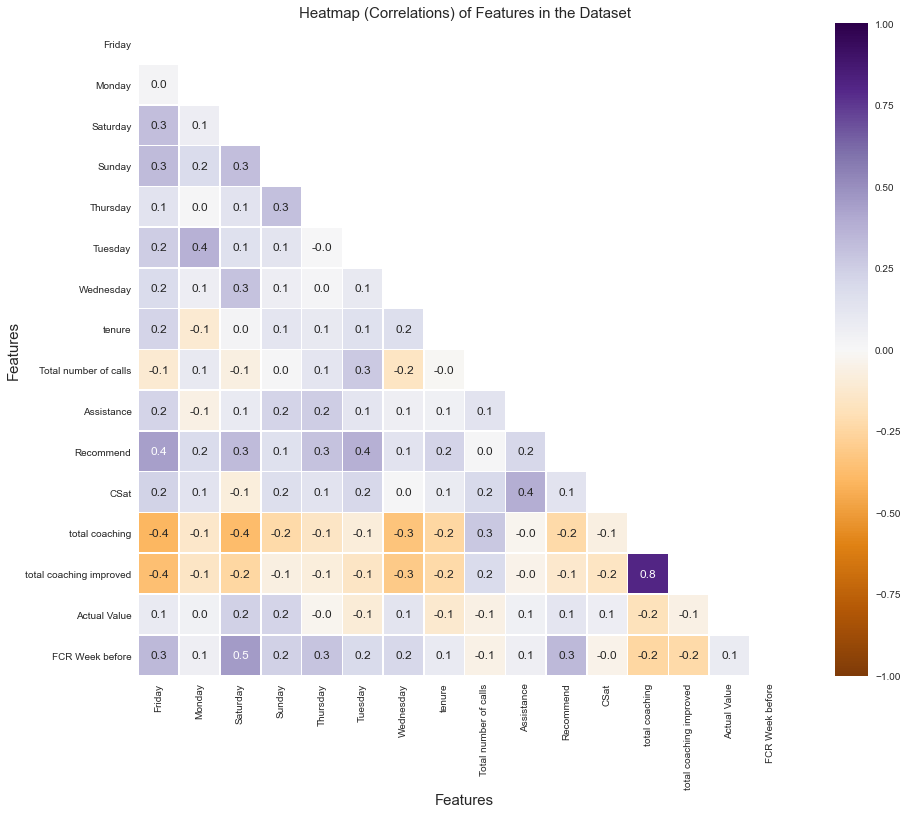

In [6]:
# Create a correlation for the dataset.
dataset_corr = dataset.corr().round(4)

# Drop Agent_ID from correlation dataset.
dataset_corr = dataset_corr.drop(["Agent_ID"], axis=1)
dataset_corr = dataset_corr.drop(["Agent_ID"], axis=0)

# Create a correlation matrix. Only bottom left corner valued. 
mask = np.zeros_like(dataset_corr.round(4))
mask[np.triu_indices_from(mask)] = True

# Generate the corrleation matrix (heatmap) using Seaborn. 
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(16, 12))
    ax = sns.heatmap(dataset_corr.round(2), mask=mask, vmax=1, center = 0, vmin=-1, square=True, cmap='PuOr', linewidths=.5, annot=True, annot_kws={"size": 12}, fmt='.1f')
    plt.title('Heatmap (Correlations) of Features in the Dataset', fontsize=15)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Features', fontsize=15)
plt.show()

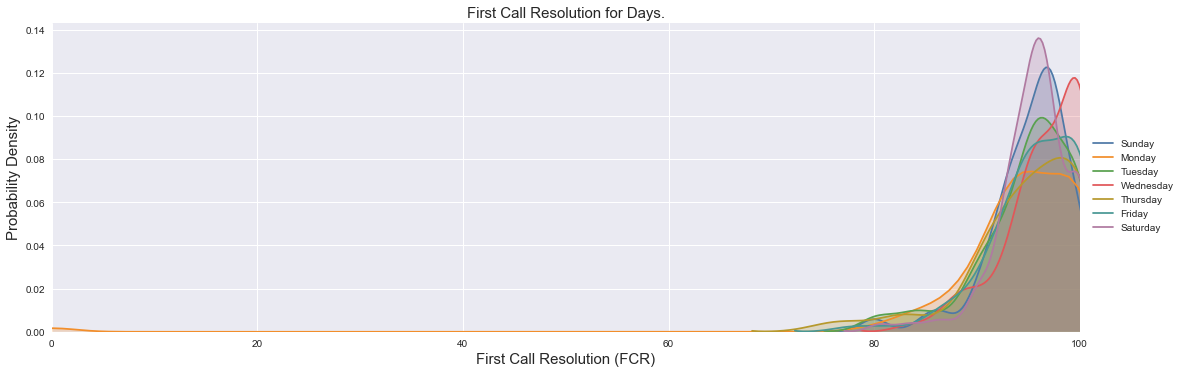

In [7]:
# Visualize the FCR for specific day in the probability density chart. 
facet = sns.FacetGrid(dataset, aspect = 3, height=5)
facet.map(sns.kdeplot, 'Sunday', shade = True, color='#4E79A7')
facet.map(sns.kdeplot, 'Monday', shade = True, color='#F28E2B')
facet.map(sns.kdeplot, 'Tuesday', shade = True, color='#59A14F')
facet.map(sns.kdeplot, 'Wednesday', shade = True, color='#E15759')
facet.map(sns.kdeplot, 'Thursday', shade = True, color='#B6992D')
facet.map(sns.kdeplot, 'Friday', shade = True, color='#499894')
facet.map(sns.kdeplot, 'Saturday', shade = True, color='#B07AA1')
facet.set(xlim = (0, dataset['Thursday'].max()))
facet.add_legend()
plt.title('First Call Resolution for Days.', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.xlabel('First Call Resolution (FCR)', fontsize=15)
plt.show()

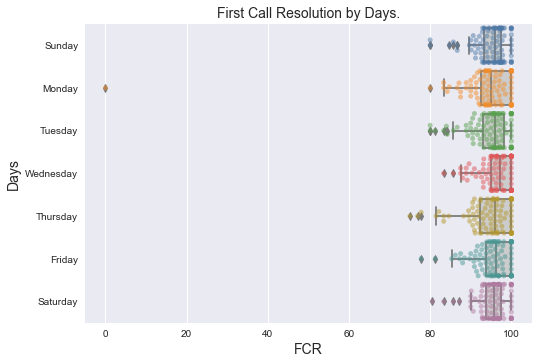

In [8]:
# Visualize the dispersion of FCR values in a given day and identify the outliers. 

# Create a color set that matches the probability density chart. 
my_pal = {'Sunday': '#4E79A7','Monday': '#F28E2B', 'Tuesday': '#59A14F', 'Wednesday': '#E15759', 'Thursday': '#B6992D', 'Friday': '#499894', 'Saturday': '#B07AA1'}

# Generate a boxplot using Seaborn. 
dataset_boxplot = pd.DataFrame(data = dataset, columns = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
sns.boxplot(x="value", y="variable", data=pd.melt(dataset_boxplot), color='#cccccc')
sns.swarmplot(x="value", y="variable", data=pd.melt(dataset_boxplot), palette=my_pal, alpha=0.5)
plt.title('First Call Resolution by Days.', fontsize=14)
plt.ylabel('Days', fontsize=14)
plt.xlabel('FCR', fontsize=14)
plt.show()

# 4. Conduct Regression Model in Pycaret

In [45]:
# Transform dataset (transform, bin and create dummy variables) and split. Note that we will 
# create a split of 95% (Train) and 5% (Test). The Test set will actually be our unseen holdout
# set for us to do our final validation. 

reg_fcr = setup(data=dataset, target='Actual Value', session_id=786, transformation=True, normalize=False, train_size=0.75, numeric_features=('Sunday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday', 'Friday', 'Total number of calls', 'CSat', 'total coaching', 'total coaching improved', 'FCR Week before'), remove_outliers=True, outliers_threshold=0.05, remove_multicollinearity=True, multicollinearity_threshold=0.9, feature_selection=True, feature_interaction=True, silent=False, ignore_features=['Agent_ID'], combine_rare_levels=True, polynomial_features=True, trigonometry_features=True, feature_selection_threshold=0.4, feature_selection_method='classic', folds_shuffle=False, log_experiment=True, experiment_name='reg_fcr_experiments', log_plots=True)


Setup Succesfully Completed.


,Description,Value
0,session_id,786
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(102, 19)"
4,Missing Values,False
5,Numeric Features,16
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [46]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model.Lasso,True
ridge,Ridge Regression,sklearn.linear_model.Ridge,True
en,Elastic Net,sklearn.linear_model.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model.OMP,True
br,Bayesian Ridge,sklearn.linear_model.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model.ARDRegression,False


In [47]:
# We can do a compare_models() function without assigning it to a variable. However, we have top 5 models selected using n_select and assigning it to top5 varilable. We plan to use this for Stacking and Blending purposes. We have black listed 'RANSAC' (Random Sample Consensus) model and have kept the default fold value of 10. 

top5 = compare_models(n_select=5, exclude=(['ransac', 'knn']), sort='RMSE', fold=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,3.5903,24.0665,4.6221,-0.1462,0.0502,0.0394,0.1548
1,CatBoost Regressor,3.8015,28.2945,4.8950,-0.0383,0.0532,0.0420,3.4613
2,Random Forest,3.8780,27.8221,4.9260,-0.1122,0.0535,0.0424,0.2729
3,Gradient Boosting Regressor,3.8187,29.2812,4.9330,-0.1078,0.0533,0.0418,0.0737
4,AdaBoost Regressor,3.8382,30.0361,4.9647,-0.0303,0.0537,0.0423,0.0831
5,Bayesian Ridge,3.8663,27.4709,5.0524,-0.4394,0.0549,0.0424,0.0095
6,Elastic Net,4.0040,29.2618,5.1531,-0.3746,0.0559,0.0439,0.0028
7,Extra Trees Regressor,4.0997,29.5892,5.1794,-0.4921,0.0560,0.0445,0.1506
8,Lasso Regression,4.2108,31.4952,5.3257,-0.4241,0.0577,0.0462,0.0038
9,Decision Tree,3.5715,34.5930,5.3512,-0.3472,0.0583,0.0393,0.0053


In [48]:
# Sometimes you want to include the output of the compare_models() as a screenshot into a report. However, with the yellow highlights it gets difficult to read. Pycaret has thought of that and you can use the pull() function to show the model results in the sort by or ascending order.

pull().sort_values(by='RMSE', ascending=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,3.5903,2.406650e+01,4.6221,-1.462000e-01,0.0502,0.0394,0.1548
1,CatBoost Regressor,3.8015,2.829450e+01,4.8950,-3.830000e-02,0.0532,0.0420,3.4613
2,Random Forest,3.8780,2.782210e+01,4.9260,-1.122000e-01,0.0535,0.0424,0.2729
3,Gradient Boosting Regressor,3.8187,2.928120e+01,4.9330,-1.078000e-01,0.0533,0.0418,0.0737
4,AdaBoost Regressor,3.8382,3.003610e+01,4.9647,-3.030000e-02,0.0537,0.0423,0.0831
5,Bayesian Ridge,3.8663,2.747090e+01,5.0524,-4.394000e-01,0.0549,0.0424,0.0095
6,Elastic Net,4.0040,2.926180e+01,5.1531,-3.746000e-01,0.0559,0.0439,0.0028
7,Extra Trees Regressor,4.0997,2.958920e+01,5.1794,-4.921000e-01,0.0560,0.0445,0.1506
8,Lasso Regression,4.2108,3.149520e+01,5.3257,-4.241000e-01,0.0577,0.0462,0.0038
9,Decision Tree,3.5715,3.459300e+01,5.3512,-3.472000e-01,0.0583,0.0393,0.0053


In [49]:
# tune multiple models dynamically
tuned_top5 = [tune_model(i, n_iter=120, optimize='RMSE') for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.2867,34.4240,5.8672,-0.0059,0.0635,0.0476
1,5.8770,56.6854,7.5290,-0.4017,0.0832,0.0676
2,2.7007,9.6281,3.1029,-0.1755,0.0318,0.0281
3,6.1630,58.0705,7.6204,0.0682,0.0827,0.0679
4,1.6481,3.2006,1.7890,0.2519,0.0181,0.0168
5,5.7914,72.9335,8.5401,-0.0428,0.0976,0.0688
6,1.8092,4.0764,2.0190,0.2562,0.0206,0.0186
7,2.5817,8.7417,2.9566,-0.1515,0.0302,0.0263
8,4.4623,21.6014,4.6477,-0.2756,0.0481,0.0460
9,4.5925,44.5915,6.6777,0.2151,0.0752,0.0534


<Figure size 576x396 with 0 Axes>

In [50]:
#what is blending

blender_specific = blend_models(estimator_list=tuned_top5[0:], fold=10, optimize='RMSE', choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.7078,25.8668,5.0859,0.2442,0.0555,0.0412
1,5.6582,53.7379,7.3306,-0.3288,0.0815,0.0656
2,2.6925,9.9394,3.1527,-0.2135,0.0323,0.0278
3,5.2495,46.4256,6.8136,0.2550,0.0741,0.0584
4,1.7837,3.5903,1.8948,0.1608,0.0192,0.0182
5,4.7185,50.9795,7.1400,0.2711,0.0830,0.0564
6,1.4296,3.1684,1.7800,0.4219,0.0182,0.0147
7,2.8302,12.6196,3.5524,-0.6623,0.0365,0.0287
8,4.4320,22.6480,4.7590,-0.3374,0.0494,0.0459
9,3.5288,35.1098,5.9254,0.3820,0.0673,0.0419


<Figure size 576x396 with 0 Axes>

In [51]:
blender_specific

VotingRegressor(estimators=[('Light Gradient Boosting Machine_0',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.4, max_depth=70,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.4, n_estimators=10,
                                           n_jobs=-1, num_leaves=150,
                                           objective=None, random_state=786,
                                           reg_alpha=0.5, reg_lambd...
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=80,
                                                       n_iter_no_change=None,
                                                       presort='deprecated',
                                                       random_state=786,
                                                       subsample=0.7,
                                                       tol=0.0001,
                                                       validation_fraction=0.1,
                                                       verbose=0,
                                                       warm_start=False)),
                            ('Ada Boost Regressor_4',
                             AdaBoostRegressor(base_estimator=None,
                                               learning_rate=0.7799999999999997,
                                               loss='linear', n_estimators=55,
                                               random_state=786))],
                n_jobs=-1, verbose=False, weights=None)

In [52]:
#what is stacking

stacker_specific = stack_models(estimator_list=tuned_top5[1:], meta_model=tuned_top5[0], fold=10, optimize='RMSE', choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.9257,13.0664,3.6147,0.6182,0.0395,0.0319
1,4.4707,36.9958,6.0824,0.0852,0.0684,0.0521
2,3.2206,14.1174,3.7573,-0.7235,0.0384,0.0332
3,5.8326,57.2294,7.5650,0.0817,0.0826,0.0653
4,2.4024,7.1186,2.6681,-0.6639,0.0270,0.0245
5,5.1858,53.4794,7.3130,0.2354,0.0845,0.0610
6,1.7329,4.8838,2.2099,0.1089,0.0229,0.0179
7,2.6285,10.6515,3.2637,-0.4031,0.0333,0.0266
8,4.0763,18.9741,4.3559,-0.1204,0.0448,0.0417
9,3.5087,28.8231,5.3687,0.4927,0.0614,0.0410


<Figure size 576x396 with 0 Axes>

In [53]:
stacker_specific

StackingRegressor(cv=10,
                  estimators=[('CatBoostRegressor_0',
                               <catboost.core.CatBoostRegressor object at 0x7fb06c2fa750>),
                              ('RandomForestRegressor_1',
                               RandomForestRegressor(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     criterion='mae',
                                                     max_depth=110,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=7...
                                                class_weight=None,
                                                colsample_bytree=1.0,
                                                importance_type='split',
                                                learning_rate=0.4, max_depth=70,
                                                min_child_samples=20,
                                                min_child_weight=0.001,
                                                min_split_gain=0.4,
                                                n_estimators=10, n_jobs=-1,
                                                num_leaves=150, objective=None,
                                                random_state=786, reg_alpha=0.5,
                                                reg_lambda=0.2, silent=True,
                                                subsample=1.0,
                                                subsample_for_bin=200000,
                                                subsample_freq=0),
                  n_jobs=-1, passthrough=True, verbose=0)

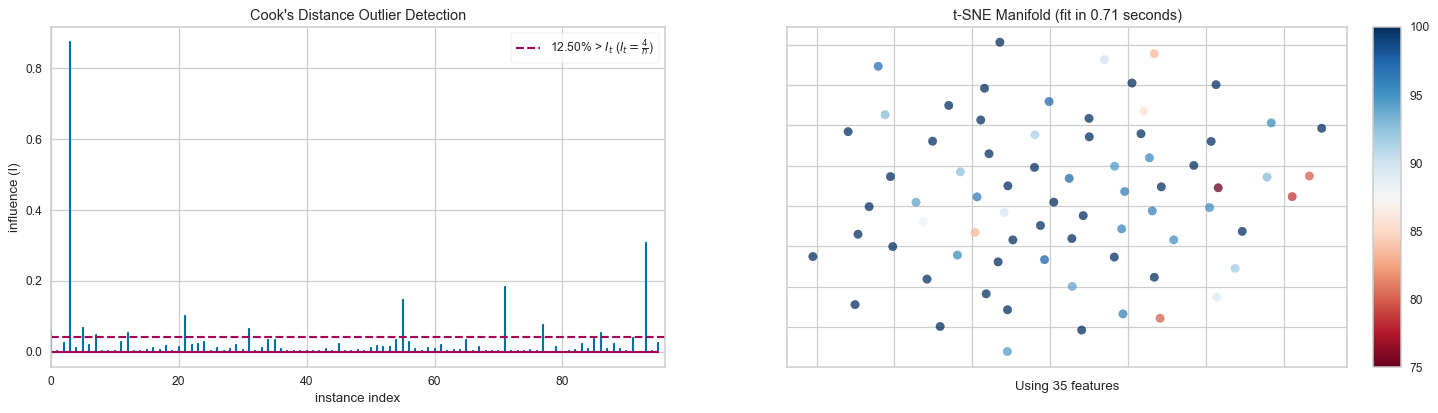

In [54]:
ax=[]
fig=[]
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,2,1)
plot_model(blender_specific, plot='cooks', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(5,2,2)
plot_model(blender_specific, plot='manifold', save=True, verbose=False, scale=1.1)
plt.savefig('plots_cooks_and_manifold.png', dpi=300, pad_inches=0.25)
plt.show()

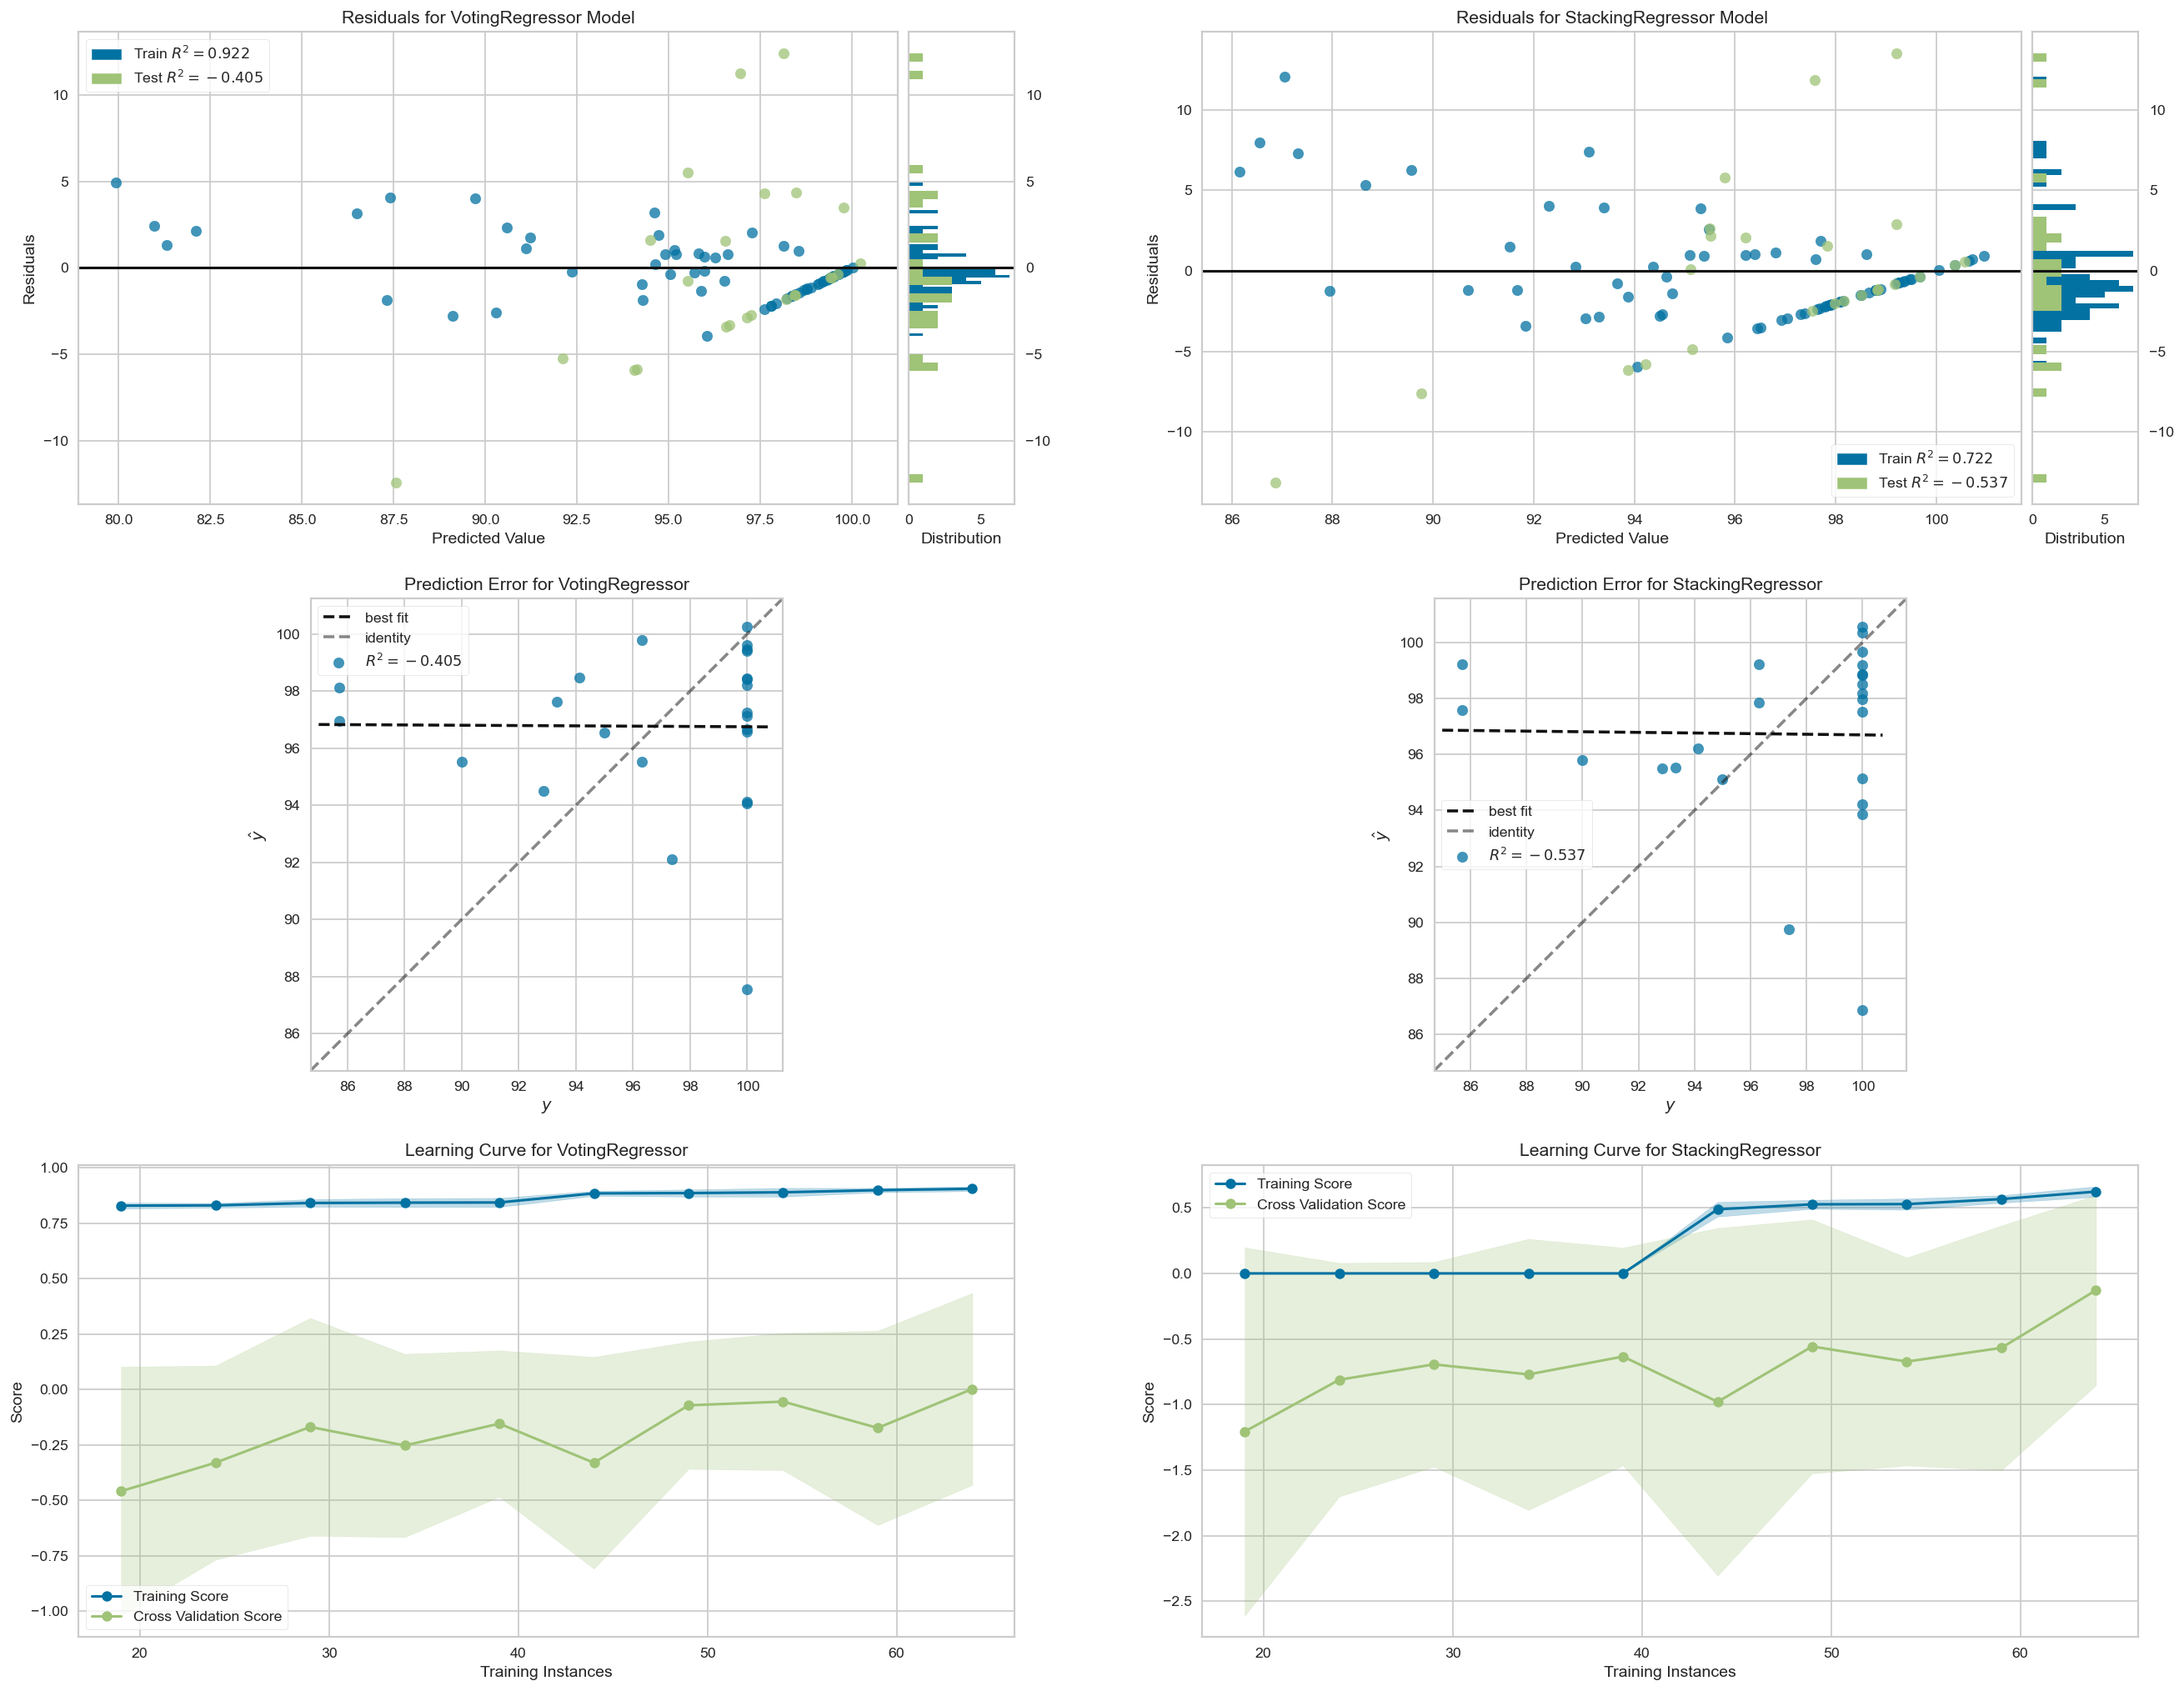

In [55]:
ax=[]
fig=[]
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(3,2,1)
plot_model(blender_specific, plot='residuals', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,2)
plot_model(stacker_specific, plot='residuals', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,3)
plot_model(blender_specific, plot='error', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,4)
plot_model(stacker_specific, plot='error', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,5)
plot_model(blender_specific, plot='learning', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,6)
plot_model(stacker_specific, plot='learning', save=True, verbose=False, scale=1.1)
plt.savefig('plots_blender_vs_stacker.png', dpi=300, pad_inches=0.25)
plt.show()

In [56]:
pred_tunded_blender = predict_model(blender_specific)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,3.9081,27.7419,5.2671,-0.405,0.0557,0.0414


In [57]:
pred_tunded_stacker = predict_model(stacker_specific)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,3.8484,30.3433,5.5085,-0.5368,0.0584,0.0409


In [58]:
finalize_blender = finalize_model(blender_specific)
finalize_blender

VotingRegressor(estimators=[('Light Gradient Boosting Machine_0',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.4, max_depth=70,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.4, n_estimators=10,
                                           n_jobs=-1, num_leaves=150,
                                           objective=None, random_state=786,
                                           reg_alpha=0.5, reg_lambd...
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=80,
                                                       n_iter_no_change=None,
                                                       presort='deprecated',
                                                       random_state=786,
                                                       subsample=0.7,
                                                       tol=0.0001,
                                                       validation_fraction=0.1,
                                                       verbose=0,
                                                       warm_start=False)),
                            ('Ada Boost Regressor_4',
                             AdaBoostRegressor(base_estimator=None,
                                               learning_rate=0.7799999999999997,
                                               loss='linear', n_estimators=55,
                                               random_state=786))],
                n_jobs=-1, verbose=False, weights=None)

<Figure size 576x396 with 0 Axes>

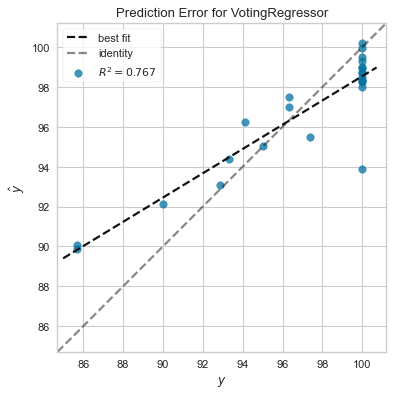

In [118]:
plot_model(finalize_blender, plot='error', save=True, verbose=False, scale=1.1)

In [60]:
pred_final_blender = predict_model(finalize_blender, data=dataset)
pred_final_blender.to_csv('pred_final_blender.csv')
pred_final_blender.describe()

,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before,Label
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,371097.882353,95.650593,94.096218,95.552565,95.186928,94.907817,94.968364,96.544911,14.235294,173.941176,95.832315,95.622119,4.807622,1.607843,0.882353,96.036176,95.578725,96.113227
std,10742.442598,4.355132,10.465289,3.558242,3.941495,5.453729,4.675461,3.829237,6.846516,77.234608,1.784522,1.997818,0.089011,1.775281,1.074402,5.700526,4.674600,4.239635
min,353039.000000,77.777778,0.000000,80.555556,80.000000,75.000000,80.000000,83.333333,3.000000,52.000000,89.655172,87.162162,4.413793,0.000000,0.000000,75.000000,80.000000,80.685200
25%,362108.000000,93.750000,92.445055,93.873767,93.284134,92.307692,92.938312,95.000000,8.000000,116.250000,94.711729,94.666667,4.767000,0.000000,0.000000,94.120000,92.920000,94.905750
50%,371781.000000,96.153846,94.935897,95.833414,96.013439,96.000000,95.861872,97.329060,15.000000,158.000000,95.806136,95.589688,4.819492,1.000000,1.000000,100.000000,96.490000,97.435100
75%,380697.750000,100.000000,100.000000,97.556895,97.568007,100.000000,98.146168,100.000000,17.000000,226.250000,96.988326,97.113066,4.865194,2.000000,1.000000,100.000000,100.000000,99.155000
max,388627.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,33.000000,388.000000,100.000000,100.000000,4.984127,9.000000,4.000000,100.000000,100.000000,100.200700


In [61]:
pred_final_blender

,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Site,Function_Field,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before,Label
index,,,,,,,,,,,,,,,,,,,,
0,384091,100.000000,90.000000,90.000000,96.145833,100.000000,96.875000,100.000000,Kuala Lumpur,Agent,33,163,95.061728,94.230769,4.865031,0,0,85.71,97.14,90.9586
1,369185,94.000000,100.000000,96.865528,96.865528,96.103896,95.890411,98.333333,Kuala Lumpur,Agent,33,306,95.081967,94.666667,4.830065,0,0,100.00,88.64,99.0672
2,360854,94.444444,80.000000,92.936027,92.936027,100.000000,93.939394,96.296296,Kuala Lumpur,Agent,32,138,94.160584,94.736842,4.818841,2,1,80.00,92.31,82.7960
3,374407,100.000000,95.000000,96.630435,96.630435,92.500000,95.652174,100.000000,Kuala Lumpur,Agent,32,148,98.648649,95.833333,4.844595,0,0,94.44,100.00,96.3179
4,372496,96.875000,95.833333,94.278101,94.278101,83.333333,95.348837,100.000000,Kuala Lumpur,Agent,29,142,97.183099,98.550725,4.859155,0,0,100.00,90.91,99.0628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,363616,98.148148,96.153846,97.516525,97.516525,97.826087,95.454545,100.000000,Kuala Lumpur,Agent,6,240,95.815900,93.913043,4.883333,1,1,100.00,95.24,99.1587
98,382506,92.452830,93.253091,95.454545,97.560976,91.666667,93.253091,89.130435,Kuala Lumpur,Agent,6,244,93.004115,92.016807,4.852459,4,3,100.00,93.10,99.3932
99,354474,95.652174,97.058824,94.317739,98.305085,89.473684,91.666667,93.750000,Kuala Lumpur,Agent,6,250,95.951417,94.628099,4.792000,0,0,90.00,89.19,91.5894


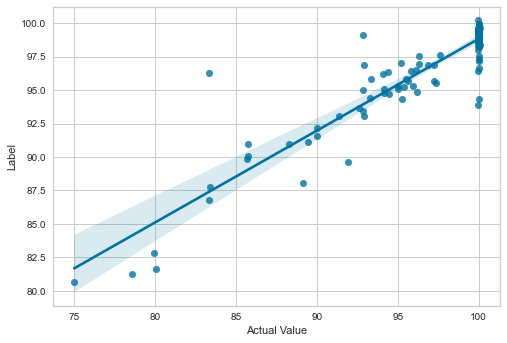

In [153]:
sns.regplot(x="Actual Value", y="Label", data=pred_final_blender, x_jitter=.05, lowess=False, scatter_kws ={'s':50})

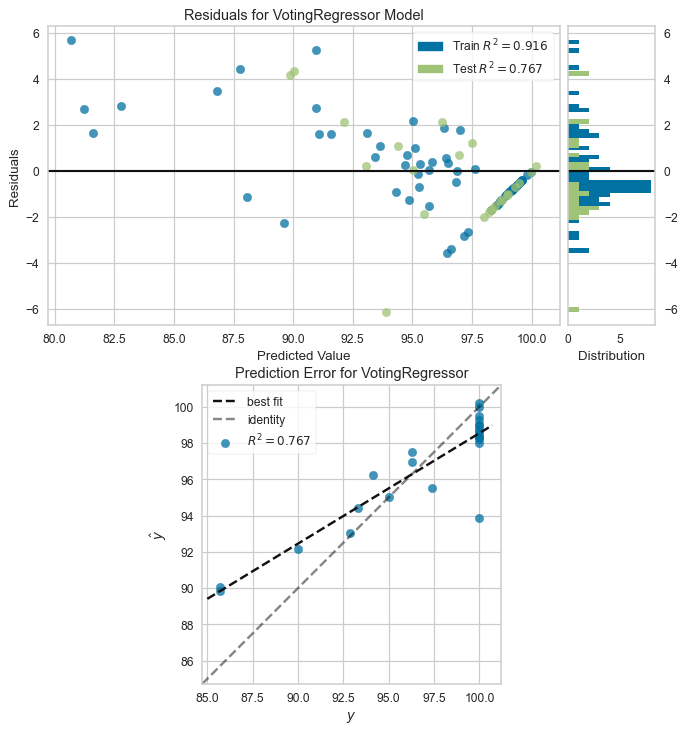

In [117]:
ax=[]
fig=[]
fig = plt.figure(figsize=(9,10))
ax = fig.add_subplot(2,1,1)
plot_model(finalize_blender, plot='residuals', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(2,1,2)
plot_model(finalize_blender, plot='error', save=True, verbose=False, scale=1.1)
plt.savefig('plots_pred_final_blender.png', dpi=300, pad_inches=0.25)
plt.show()

In [115]:
interpret_model(finalize_blender, plot = 'reason')

SystemExit: (Type Error): This function only supports tree based models.

In [17]:
!mlflow ui

[2020-08-29 13:08:09 -0500] [16954] [INFO] Starting gunicorn 20.0.4
[2020-08-29 13:08:09 -0500] [16954] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2020-08-29 13:08:09 -0500] [16954] [ERROR] Retrying in 1 second.
[2020-08-29 13:08:10 -0500] [16954] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2020-08-29 13:08:10 -0500] [16954] [ERROR] Retrying in 1 second.
[2020-08-29 13:08:11 -0500] [16954] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2020-08-29 13:08:11 -0500] [16954] [ERROR] Retrying in 1 second.
[2020-08-29 13:08:12 -0500] [16954] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2020-08-29 13:08:12 -0500] [16954] [ERROR] Retrying in 1 second.
[2020-08-29 13:08:13 -0500] [16954] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2020-08-29 13:08:13 -0500] [16954] [ERROR] Retrying in 1 second.
[2020-08-29 13:08:14 -0500] [16954] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.


In [21]:
!mlflow --help

Usage: mlflow ui [OPTIONS]

  Launch the MLflow tracking UI for local viewing of run results. To launch
  a production server, use the "mlflow server" command instead.

  The UI will be visible at http://localhost:5000 by default, and only
  accept connections from the local machine. To let the UI server accept
  connections from other machines, you will need to pass ``--host 0.0.0.0``
  to listen on all network interfaces (or a specific interface address).

Options:
  --backend-store-uri PATH     URI to which to persist experiment and run
                               data. Acceptable URIs are SQLAlchemy-compatible
                               database connection strings (e.g.
                               'sqlite:///path/to/file.db') or local
                               filesystem URIs (e.g.
                               'file:///absolute/path/to/directory'). By
                               default, data will be logged to the ./mlruns
                               director

# 5. Conduct Classification Model in Pycaret

# 3.1 Predict on new data with finalized Blender Specific model

# 9. Sources and References

Scikit Learn: Learn: Machine learning in Python - scikit-learn 0.16.1 documentation. (n.d.). Retrieved June 11, 2020, from https://scikit-learn.org/

Pycaret. (2020, May 11). Retrieved June 11, 2020, from https://pycaret.org/

TensorFlow. (n.d.). Retrieved June 12, 2020, from https://www.tensorflow.org/

Team, K. (n.d.). Simple. Flexible. Powerful. Retrieved June 12, 2020, from https://keras.io/

Scikit Learn Optimize. (n.d.). Retrieved June 12, 2020, from https://scikit-optimize.github.io/stable/index.html